# Part 2

## Task A

Total accident records read:27540
Number of incidents recorded in Leeds Central area:4808
Total number of accidents in selected areas:815


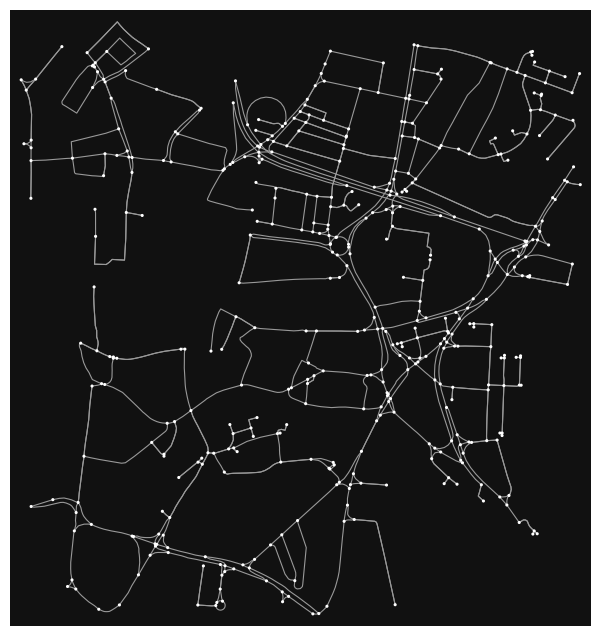

d:\python非关系数据库\Lib\site-packages\osmnx\simplification.py:586: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = gdf_nodes.buffer(tolerance).union_all()
d:\python非关系数据库\Lib\site-packages\osmnx\simplification.py:550: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return _merge_nodes_geometric(G, tolerance).centroid



Task A Final Result
1. Selected area coordinates: Latitude 53.7915 to 53.8015，Longitude -1.5428 to -1.5328
2. Spatial diameter: 46
   Average street length:61.83
   Node density:68.31
   Intersection density:58.74
   Edge density:7462.20
3. Average circuitry of the network:1.05 → High efficiency
4. Is the network planar? No


In [125]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, box
from osmnx import graph_to_gdfs
from shapely.ops import unary_union

ox.settings.use_cache = True
ox.settings.log_console = True

# Read all CSV files and extract Easting/Northing coordinates 
folder_path = "D://kcl/Network Data Analysis/assessment/datasets2"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]
df_list = []
for file in all_files:
    df = pd.read_csv(file, encoding='latin1')
    for east_col in ['Easting', 'Grid Ref: Easting']:
        for north_col in ['Northing', 'Grid Ref: Northing']:
            if east_col in df.columns and north_col in df.columns:
                df_clean = df[[east_col, north_col]].dropna()
                df_clean.columns = ['Easting', 'Northing']
                df_list.append(df_clean)
                break
accidents_df = pd.concat(df_list, ignore_index=True)
print(f"Total accident records read:{len(accidents_df)}")

# Convert to GeoDataFrame and convert to latitude and longitude coordinate system to fit OSM
gdf = gpd.GeoDataFrame(
    accidents_df,
    geometry=gpd.points_from_xy(accidents_df['Easting'], accidents_df['Northing']),
    crs="EPSG:27700"
)
gdf = gdf.to_crs("EPSG:4326")

# Filter incidents in the general central area of Leeds
gdf = gdf.cx[-1.6:-1.52, 53.79:53.81]
print(f"Number of incidents recorded in Leeds Central area:{len(gdf)}")

# Construct a 3x3 grid area and find the area with the most accidents
lat_center, lon_center = 53.7965, -1.5478
offset = 0.005
areas = []
for i in [-1, 0, 1]:
    for j in [-1, 0, 1]:
        lat_min = lat_center + i * offset
        lat_max = lat_min + 2 * offset
        lon_min = lon_center + j * offset
        lon_max = lon_min + 2 * offset
        region = box(lon_min, lat_min, lon_max, lat_max)
        count = gdf[gdf.geometry.within(region)].shape[0]
        areas.append((region, count, (lat_min, lat_max, lon_min, lon_max)))
selected = max(areas, key=lambda x: x[1])
selected_poly, selected_count, selected_bbox = selected
print(f"Total number of accidents in selected areas:{selected_count}")

# Extract the selected area road network (only drivable roads) using osmnx
center_point = ((selected_bbox[0] + selected_bbox[1]) / 2, (selected_bbox[2] + selected_bbox[3]) / 2)
G = ox.graph.graph_from_point(
    center_point,
    dist=800,
    network_type='drive'
)
# Visualizing road networks
fig, ax = ox.plot_graph(G, node_size=5, edge_linewidth=0.8)

# Calculate basic road network indicators
G_proj = ox.project_graph(G)
gdf_edges = graph_to_gdfs(G_proj, nodes=False)
gdf_edges_proj = gdf_edges.to_crs(epsg=3857)
area = gdf_edges_proj.geometry.union_all().convex_hull.area
stats = ox.basic_stats(G, area=area, clean_int_tol=15)
circuitry = stats['circuity_avg']
is_planar = nx.check_planarity(G.to_undirected())[0]

# Output analysis results
print("\nTask A Final Result")
print(f"1. Selected area coordinates: Latitude {selected_bbox[0]:.4f} to {selected_bbox[1]:.4f}，Longitude {selected_bbox[2]:.4f} to {selected_bbox[3]:.4f}")
G_undirected = G.to_undirected()
largest_cc = max(nx.connected_components(G_undirected), key=len)
G_lcc = G_undirected.subgraph(largest_cc)
diameter = nx.diameter(G_lcc)
print(f"2. Spatial diameter: {diameter}")
print(f"   Average street length:{stats['street_length_avg']:.2f}")
print(f"   Node density:{stats['node_density_km']:.2f}")
print(f"   Intersection density:{stats['intersection_density_km']:.2f}")
print(f"   Edge density:{stats['edge_density_km']:.2f}")
print(f"3. Average circuitry of the network:{circuitry:.2f} → {'High efficiency' if circuitry <= 1.1 else 'Less efficient'}")
print(f"4. Is the network planar? {'Yes' if is_planar else 'No'}")


## Task B

C:\Users\86180\AppData\Local\Temp\ipykernel_18016\3027934437.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  road_union = gdf_edges_plot.geometry.unary_union


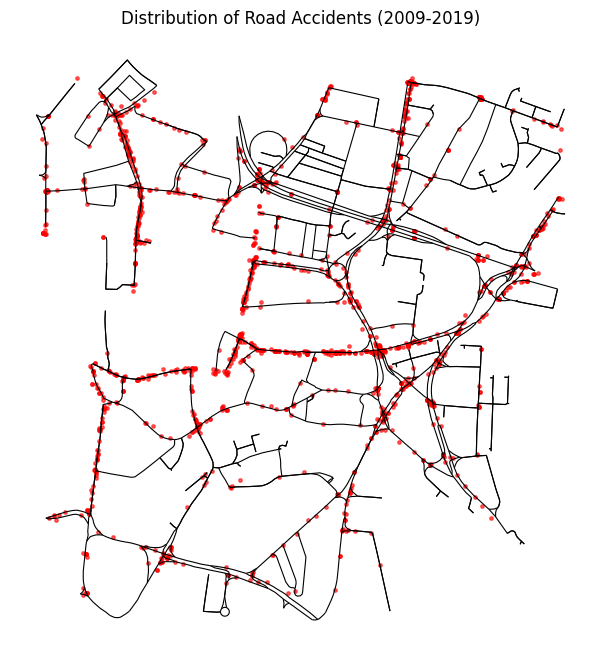

In [126]:
import spaghetti as spgh
from esda.moran import Moran
from libpysal import weights
from shapely.ops import nearest_points
from scipy.spatial.distance import pdist
from shapely.geometry import Polygon

# Filter only incidents within a specific area
gdf_edges_plot = gdf_edges.to_crs(epsg=4326)
road_union = gdf_edges_plot.geometry.unary_union
buffered_road = road_union.buffer(0.0002)
gdf_clipped = gdf[gdf.geometry.within(buffered_road)]

# Accident distribution map
fig, ax = plt.subplots(figsize=(8, 8))
gdf_edges_plot.plot(ax=ax, linewidth=0.8, color="black")
gdf_clipped.plot(ax=ax, color='red', markersize=6, alpha=0.6)
plt.title("Distribution of Road Accidents (2009-2019)")
plt.axis("off")
plt.show()

Moran's I = -0.0012, p-value = 0.4420


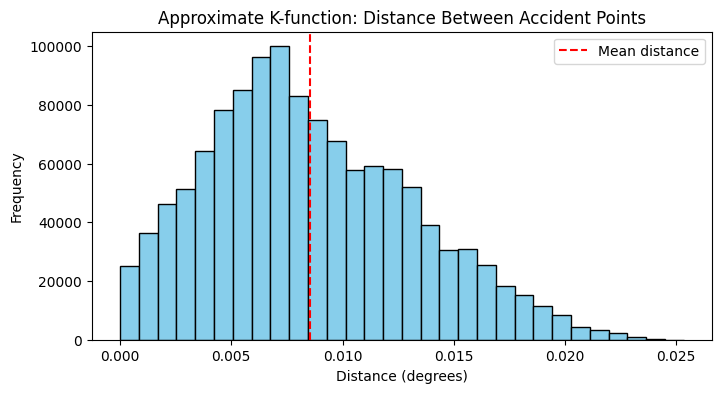

In [127]:
# Investigate whether a high number of accidents on one road correlates with a high number on connecting roads
from esda.moran import Moran
from libpysal import weights
from scipy.spatial.distance import pdist

# Count the number of accidents on each road
edge_sindex = gdf_edges_plot.sindex
edge_acc_counts = pd.Series(0, index=gdf_edges_plot.index)
for pt in gdf_clipped.geometry:
    pos_idx = list(edge_sindex.nearest(pt, 1))[0]
    edge_id = gdf_edges_plot.index[pos_idx]
    edge_acc_counts[edge_id] += 1
gdf_edges_plot["acc_count"] = edge_acc_counts

# Calculate Moran's I
w = weights.Queen.from_dataframe(gdf_edges_plot, use_index=True)
moran = Moran(gdf_edges_plot["acc_count"], w)
print(f"Moran's I = {moran.I:.4f}, p-value = {moran.p_sim:.4f}")

# k-function
coords = np.array([(pt.x, pt.y) for pt in gdf_clipped.geometry])
dists = pdist(coords)

plt.figure(figsize=(8, 4))
plt.hist(dists, bins=30, color='skyblue', edgecolor='black')
plt.title("Approximate K-function: Distance Between Accident Points")
plt.xlabel("Distance (degrees)")
plt.ylabel("Frequency")
plt.axvline(np.mean(dists), color='red', linestyle='--', label='Mean distance')
plt.legend()
plt.show()

d:\python非关系数据库\Lib\site-packages\spaghetti\network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
d:\python非关系数据库\Lib\site-packages\spaghetti\util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
d:\python非关系数据库\Lib\site-packages\libpysal\cg\shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


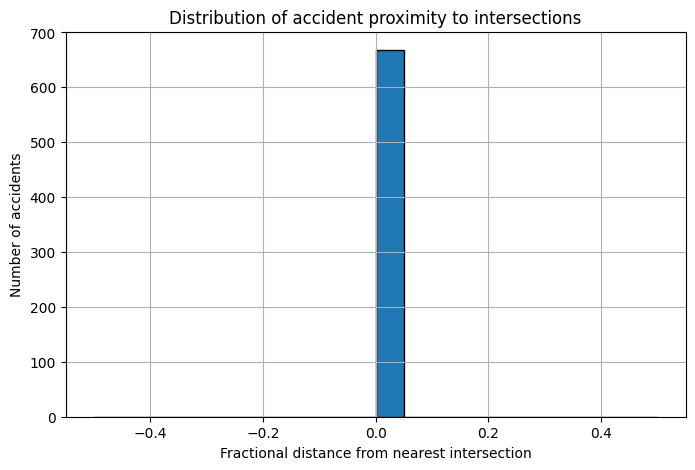

In [134]:
from shapely.geometry import Point as ShapelyPoint

# Investigate whether accidents occur nearer to intersections or partway along roads   
gdf_edges = gdf_edges.to_crs(gdf.crs)
net = spgh.Network(in_data=gdf_edges)
snapped_points = [tuple(point.coords)[0] for point in gdf_clipped.geometry]
ids = list(range(len(snapped_points)))
pp = spgh.PointPattern(gdf_clipped)
net.snapobservations(gdf_clipped, name='accidents', attribute=True)
edges_gdf = spgh.element_as_gdf(net, pp_name='accidents')
pp = net.pointpatterns["accidents"]
snapped_coords = pp.snapped_coordinates
obs_to_arc = pp.obs_to_arc

fractions = []
for snapped_point, edge_id in obs_to_arc.items():
    if isinstance(edge_id, dict):
        edge_id = list(edge_id.keys())[0]
    try:
        edge_geom = edges_gdf.loc[edge_id, 'geometry']
        seg_length = edge_geom.length
        start = edge_geom.coords[0]
        end = edge_geom.coords[-1]
        dist_to_start = ShapelyPoint(snapped_point).distance(ShapelyPoint(start))
        dist_to_end = ShapelyPoint(snapped_point).distance(ShapelyPoint(end))
        frac = min(dist_to_start, dist_to_end) / seg_length if seg_length > 0 else 0
        fractions.append(frac)
    except Exception as e:
        print("Skipping due to error:", e)
        continue

# Visualization
plt.figure(figsize=(8, 5))
plt.hist(fractions, bins=20, edgecolor='black')
plt.xlabel('Fractional distance from nearest intersection')
plt.ylabel('Number of accidents')
plt.title('Distribution of accident proximity to intersections')
plt.grid(True)
plt.show()